# Clustering summaries

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np

In [2]:
df = pd.read_csv('data/ilpd-clustered.csv')

In [3]:
clustering_columns = [col for col in df.columns if 'cluster' in col.lower()]

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_columns = [col for col in numerical_columns if col not in clustering_columns]

continuous_feature_columns = [col for col in feature_columns if col != 'Label']

In [4]:
# Calculate gender proportions for each clustering method
gender_stats = {}

for cluster_col in clustering_columns:
    unique_clusters = sorted(df[cluster_col].unique())
    
    gender_stats[cluster_col] = {}
    
    for cluster in unique_clusters:
        cluster_data = df[df[cluster_col] == cluster]
        gender_counts = cluster_data['Gender'].value_counts()
        total_count = len(cluster_data)
        
        gender_proportions = gender_counts / total_count
        
        gender_stats[cluster_col][f'cluster_{cluster}'] = {
            'total_count': total_count,
            'gender_counts': gender_counts.to_dict(),
            'gender_proportions': gender_proportions.to_dict()
        }

In [5]:
# Create comprehensive summary DataFrames including gender
comprehensive_summary = []

for cluster_method in clustering_columns:
    unique_clusters = sorted(df[cluster_method].unique())
    
    for cluster in unique_clusters:
        cluster_id = str(cluster)
        
        cluster_data = df[df[cluster_method] == cluster][feature_columns]
        means = cluster_data.mean()
        medians = cluster_data.median()
        stds = cluster_data.std()
        
        gender_info = gender_stats[cluster_method][f'cluster_{cluster}']
        
        base_row = {
            'Clustering_Method': cluster_method,
            'Cluster': cluster_id,
            'Sample_Count': gender_info['total_count']
        }
        
        for feature in feature_columns:
            base_row[f'{feature}_Mean'] = means[feature]
            base_row[f'{feature}_Median'] = medians[feature]
            base_row[f'{feature}_Std'] = stds[feature]
        
        for gender, proportion in gender_info['gender_proportions'].items():
            base_row[f'Gender_{gender}_Proportion'] = proportion
            base_row[f'Gender_{gender}_Count'] = gender_info['gender_counts'][gender]
        
        comprehensive_summary.append(base_row)

comprehensive_df = pd.DataFrame(comprehensive_summary)

In [7]:
comprehensive_df.to_csv('data/ilpd-clustering_summary.csv', index=False)

# CLUSTER COMPARISON

## Spectral Clustering

In [ ]:
comprehensive_df = pd.read_csv('data/ilpd-clustering_summary.csv')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

spectral_methods = [col for col in clustering_columns if 'spectral' in col.lower()]
spectral_data = comprehensive_df[comprehensive_df['Clustering_Method'].isin(spectral_methods)].copy()

spectral_data['k_value'] = spectral_data['Clustering_Method'].str.extract(r'k(\d+)').astype(int)
spectral_data = spectral_data.sort_values(['k_value', 'Cluster'])

# Get feature columns
print(f"Spectral clustering methods found: {spectral_methods}")
print(f"K values available: {sorted(spectral_data['k_value'].unique())}")

Spectral clustering methods found: ['Clusters_Spectral_k2', 'Clusters_Spectral_k4', 'Clusters_Spectral_k6']
K values available: [2, 4, 6]


## Sample Count per Cluster

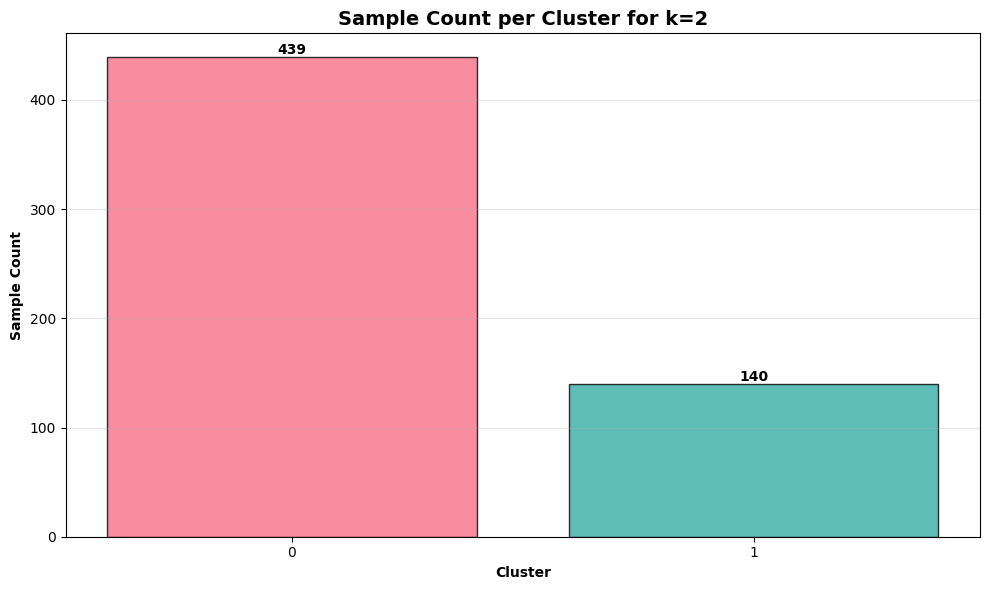

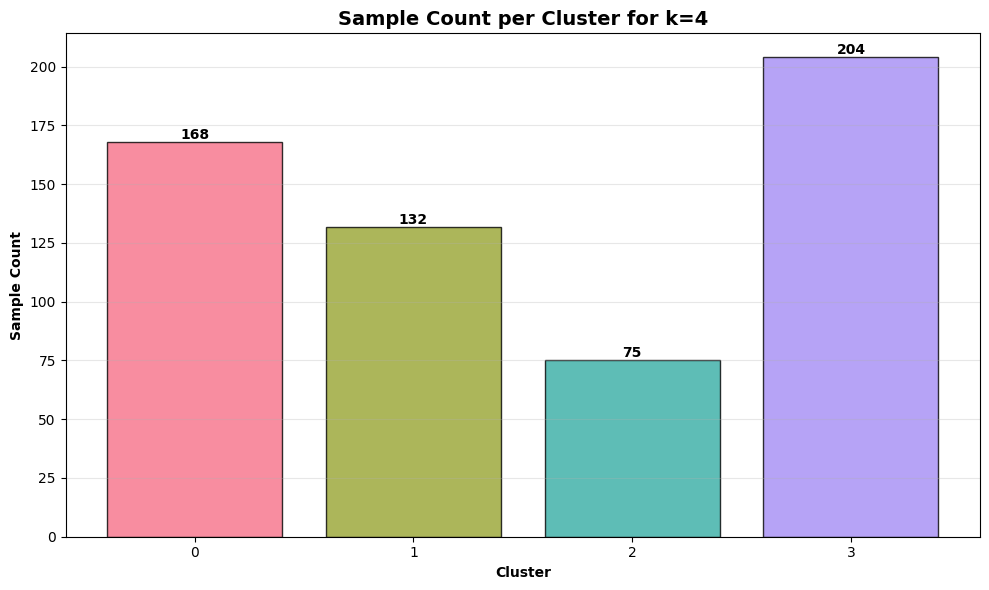

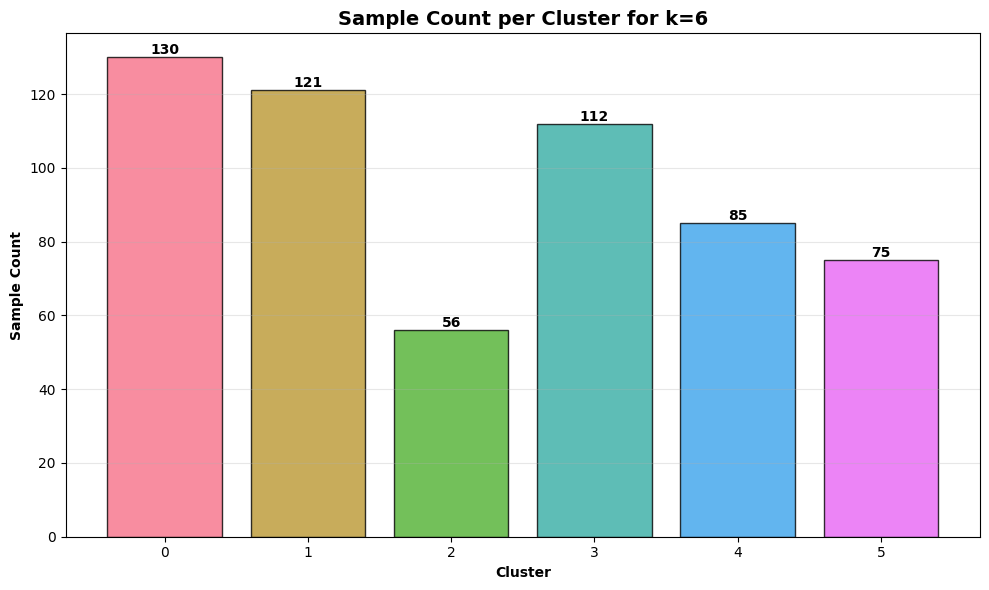

In [10]:
def plot_sample_count_by_k(k_value):
    k_data = spectral_data[spectral_data['k_value'] == k_value].copy()
    k_data = k_data.sort_values('Cluster')
    
    plt.figure(figsize=(10, 6))
    
    clusters = k_data['Cluster'].astype(str)
    sample_counts = k_data['Sample_Count']
    
    colors = sns.color_palette("husl", len(clusters))
    
    bars = plt.bar(clusters, sample_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
    plt.title(f'Sample Count per Cluster for k={k_value}', fontweight='bold', fontsize=14)
    plt.xlabel('Cluster', fontweight='bold')
    plt.ylabel('Sample Count', fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()

k_values = sorted(spectral_data['k_value'].unique())
for k in k_values:
    plot_sample_count_by_k(k)

## Feature Boxplots

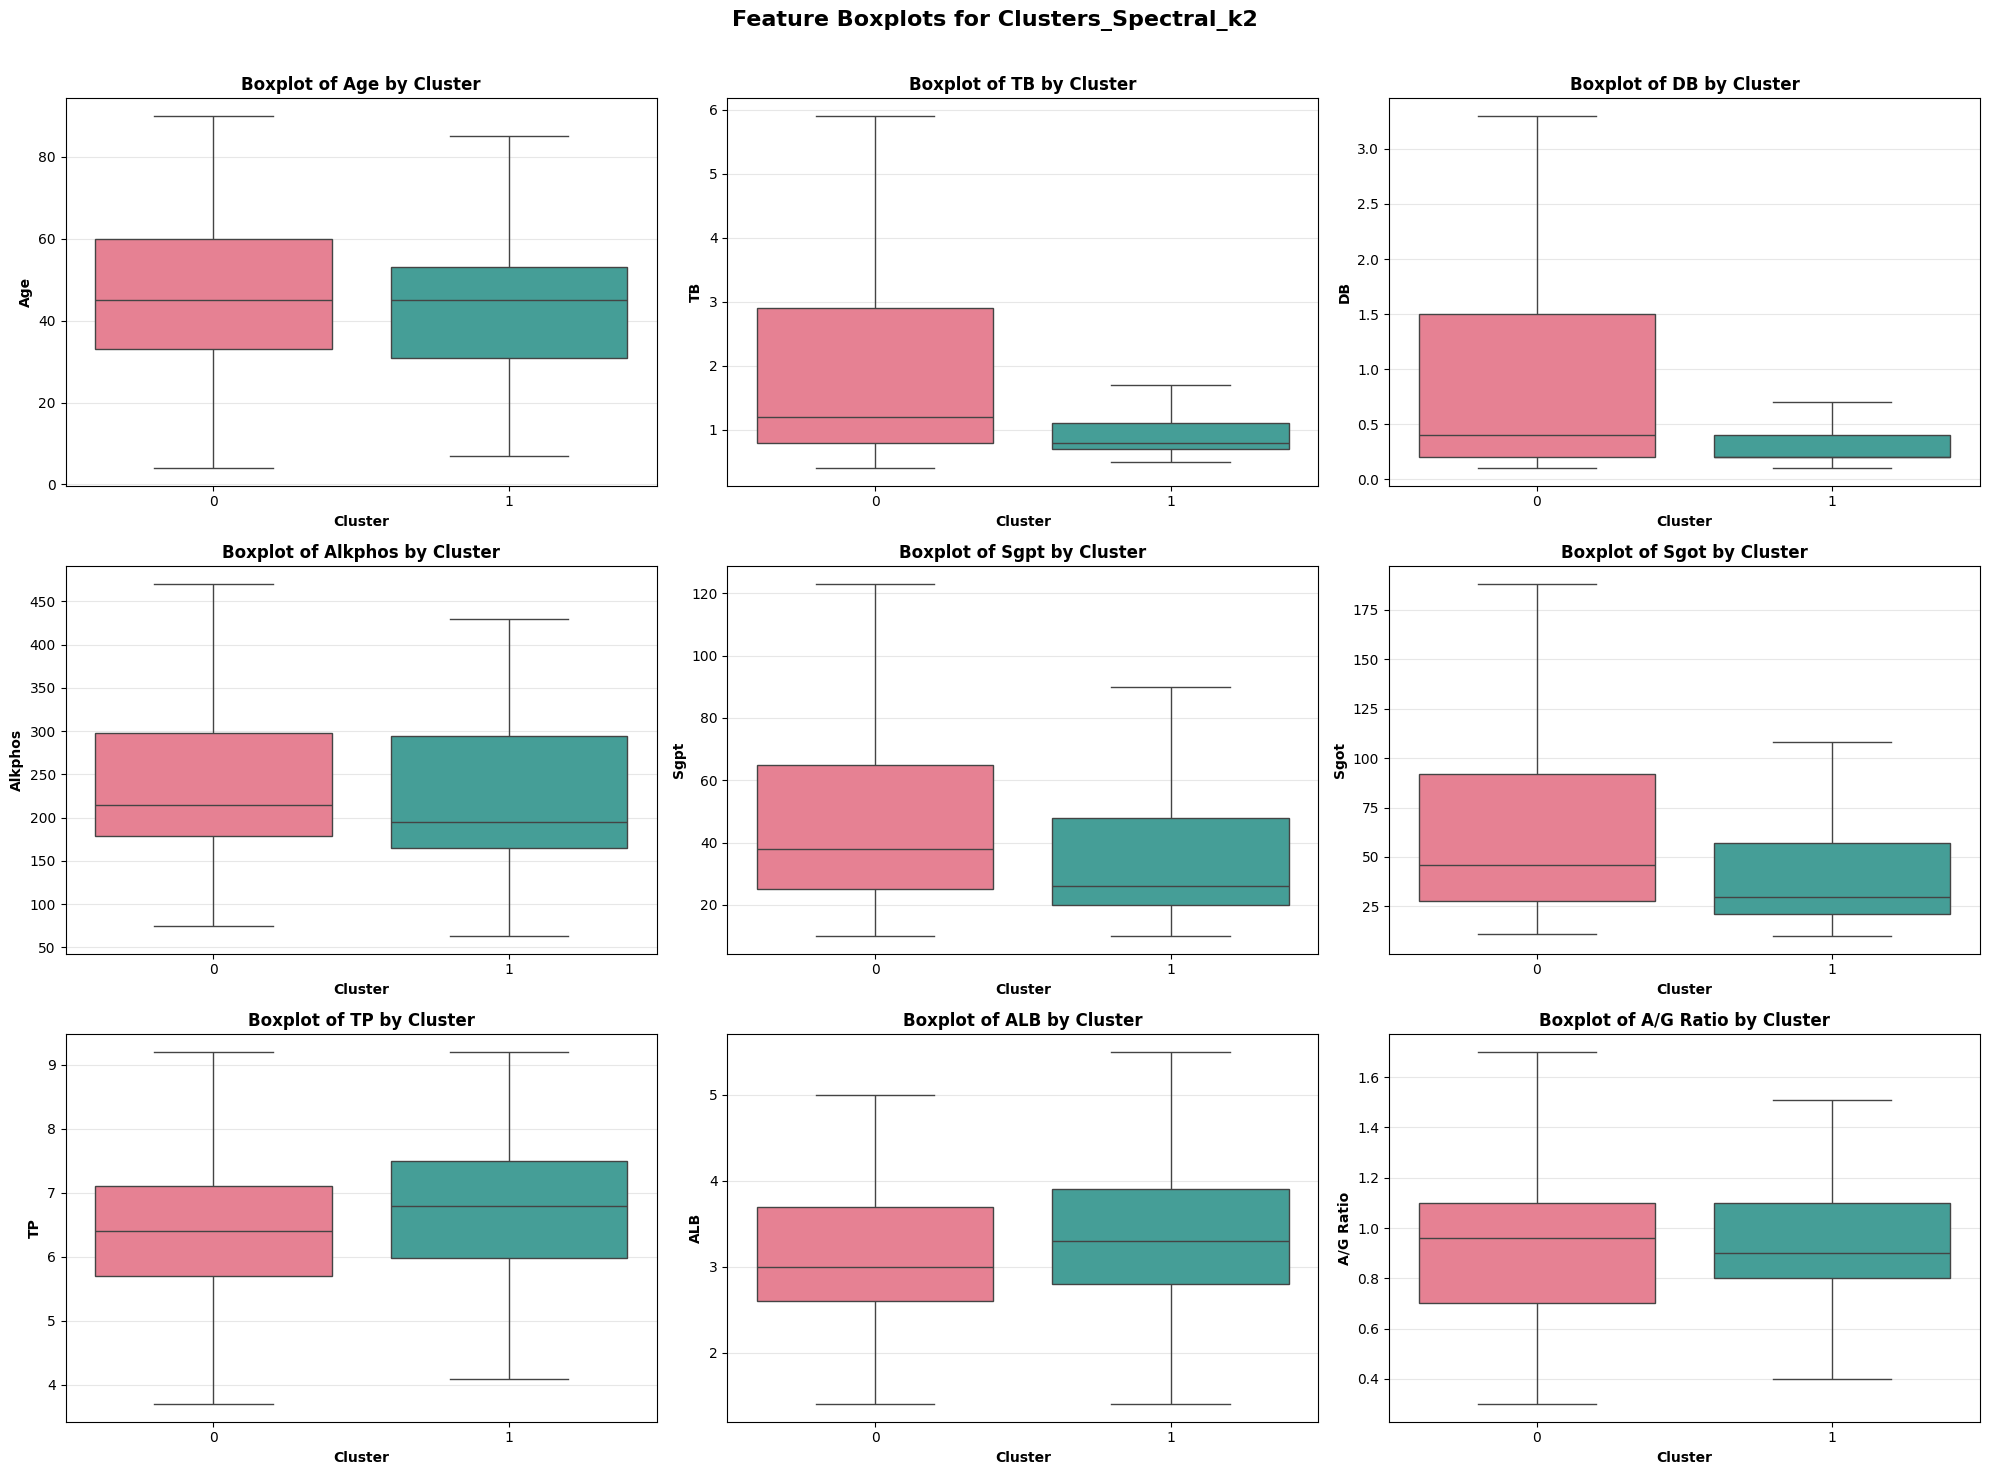

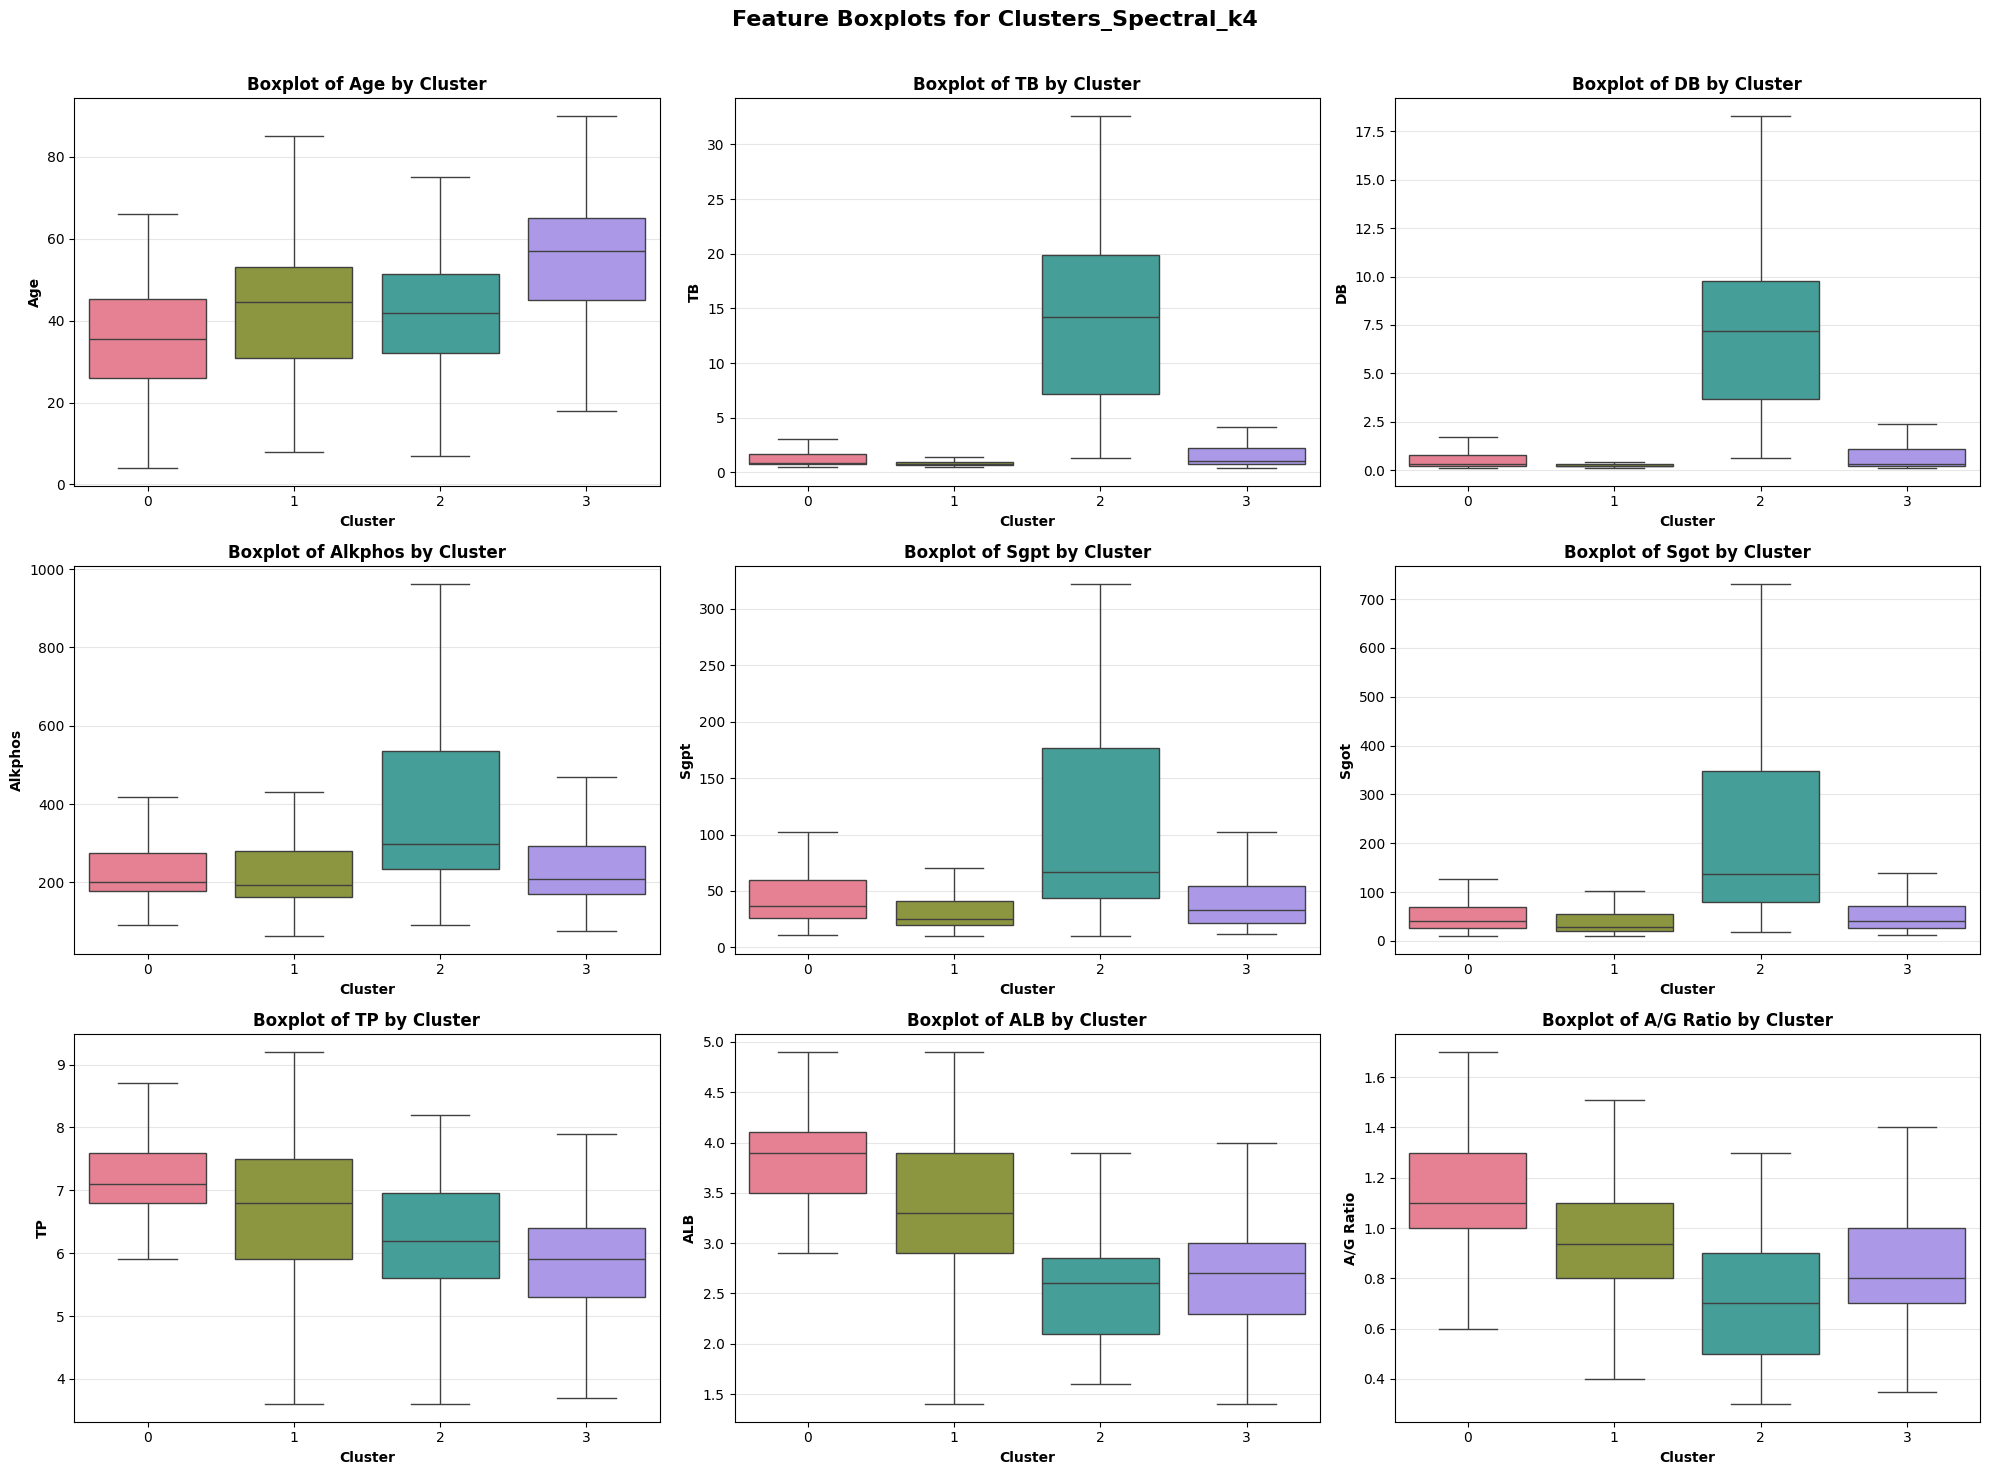

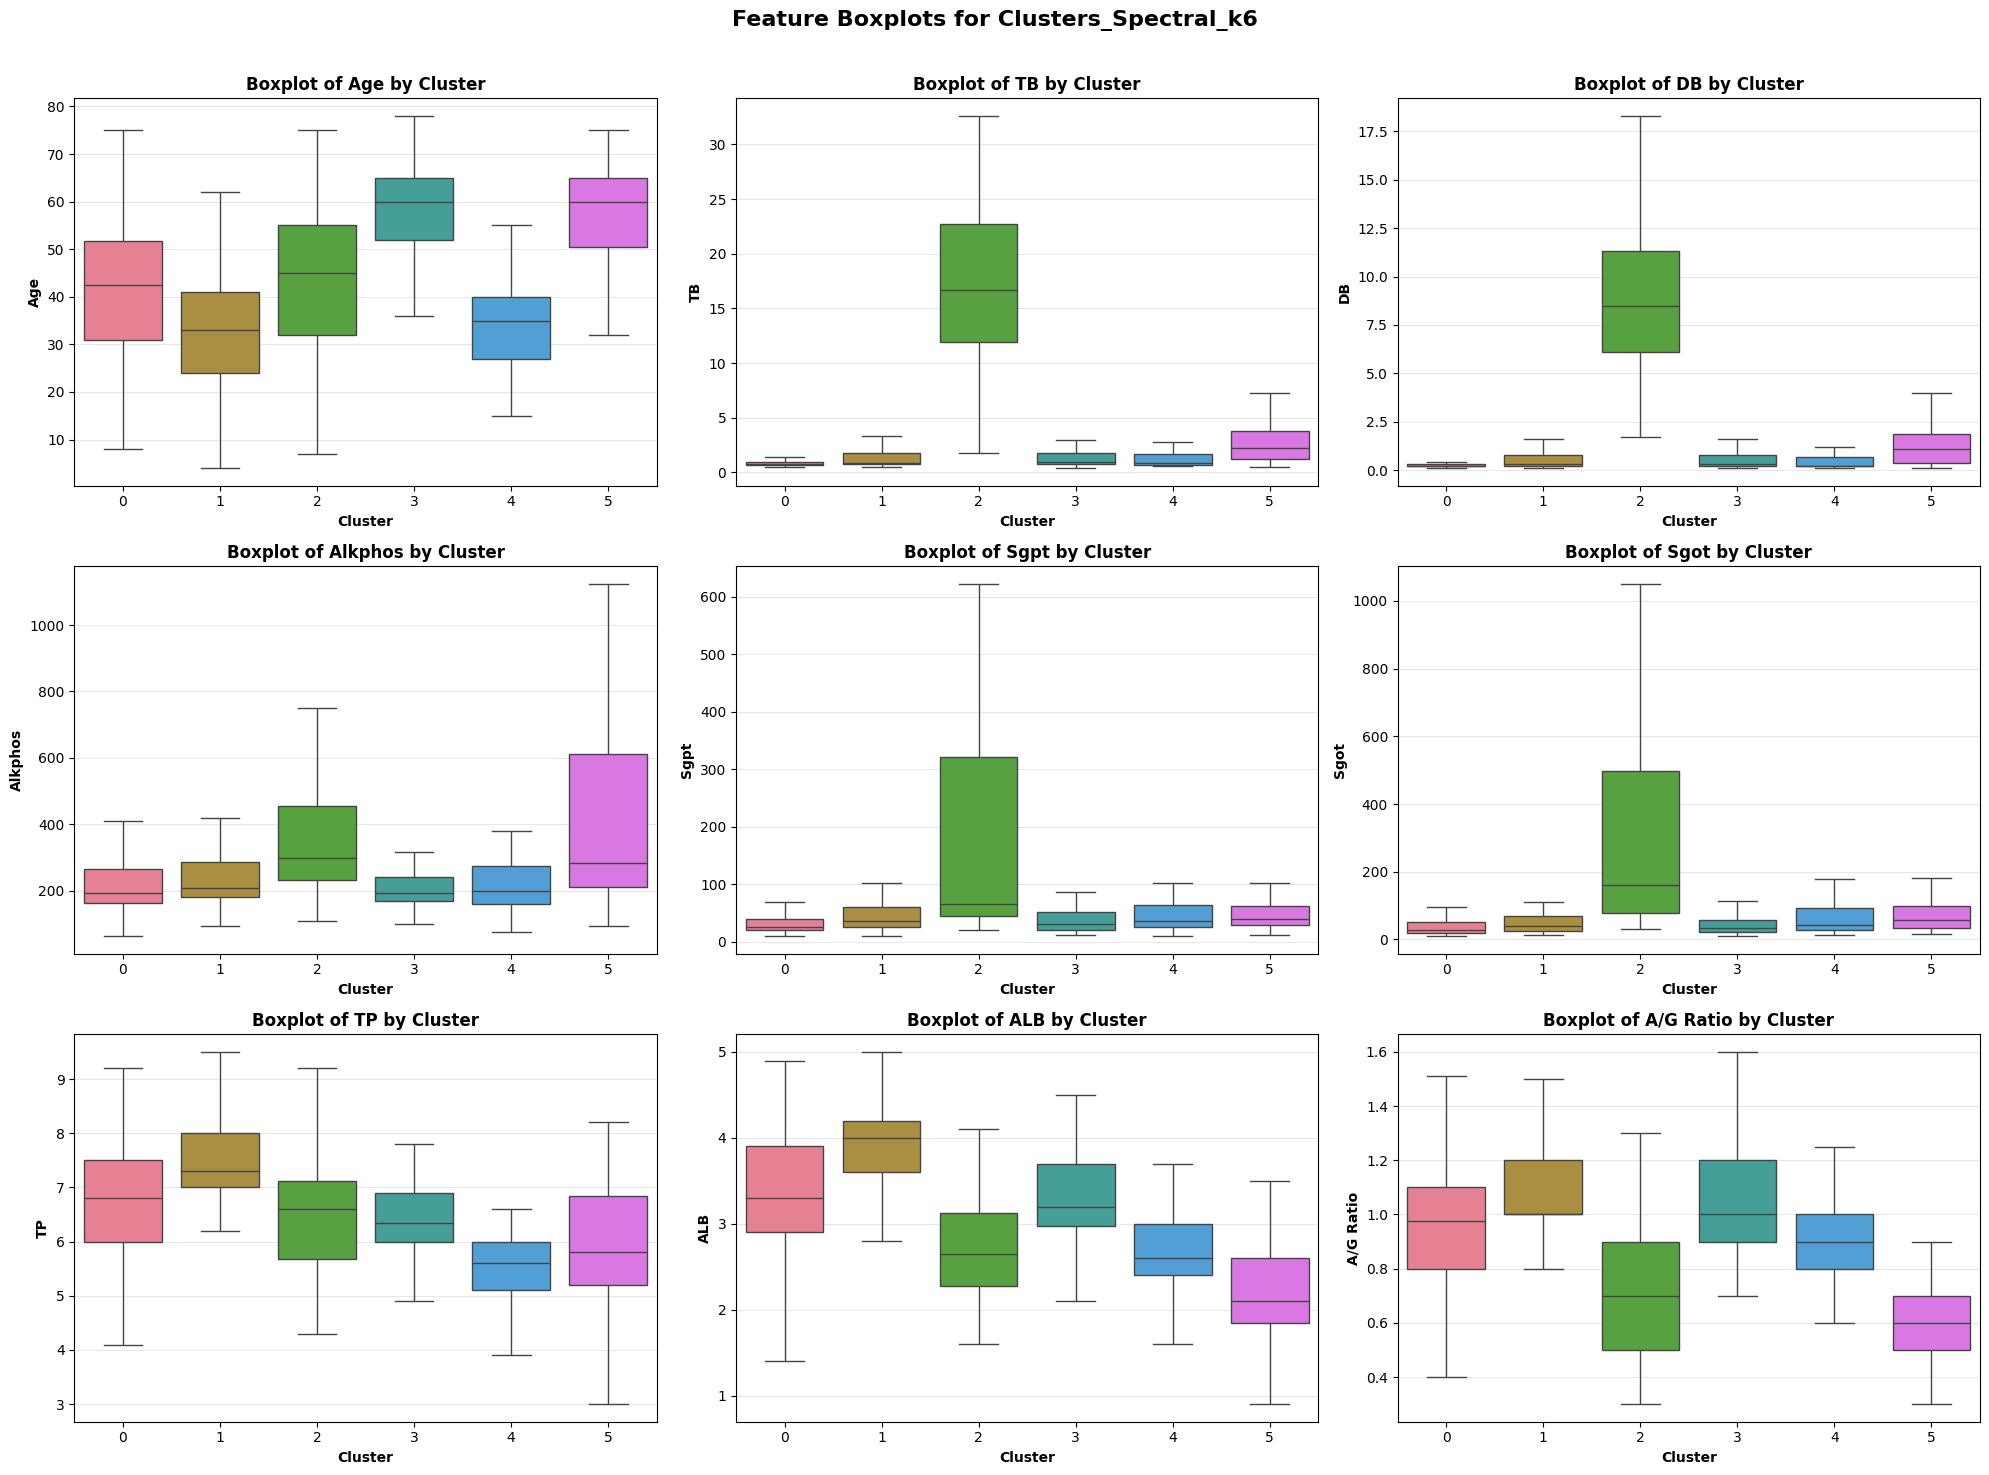

In [11]:
def plot_feature_boxplots(cluster_col):
    n_features = len(continuous_feature_columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    for i, feature in enumerate(continuous_feature_columns):
        ax = axes[i]
        sns.boxplot(x=cluster_col, y=feature, data=df, ax=ax, palette='husl', showfliers=False)
        ax.set_title(f'Boxplot of {feature} by Cluster', fontweight='bold', fontsize=12)
        ax.set_xlabel('Cluster', fontweight='bold')
        ax.set_ylabel(feature, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
    
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    fig.suptitle(f'Feature Boxplots for {cluster_col}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

for method in spectral_methods:
    plot_feature_boxplots(method)

## Distribution of Liver Disease Diagnosis

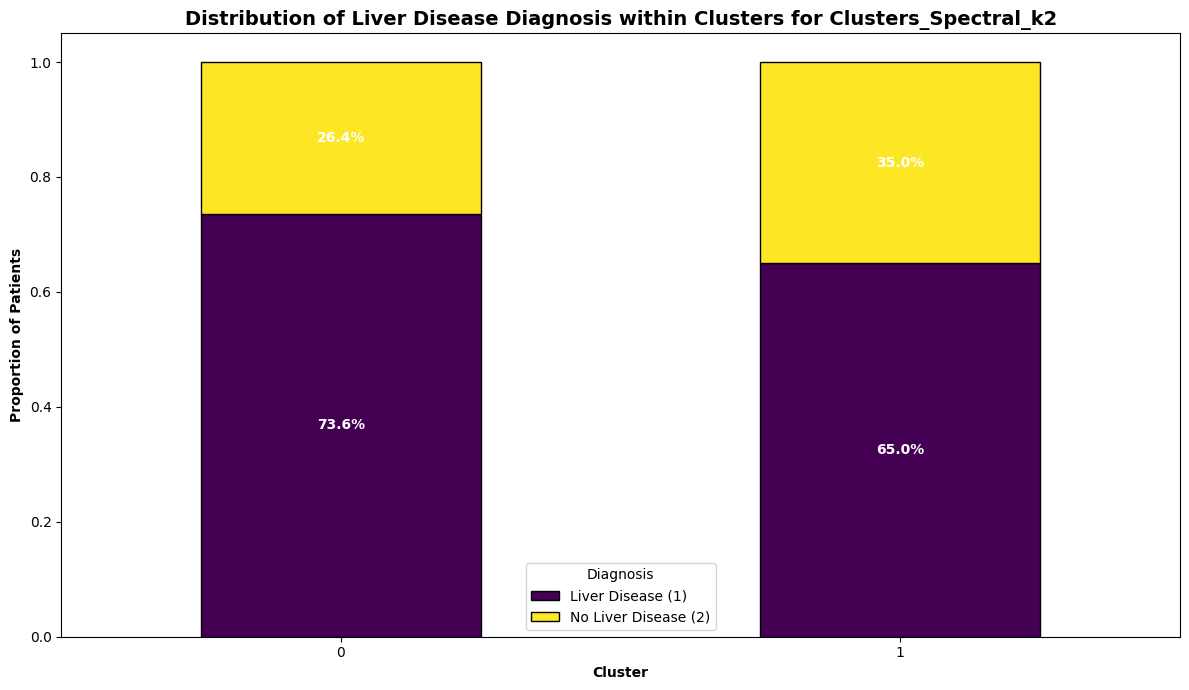

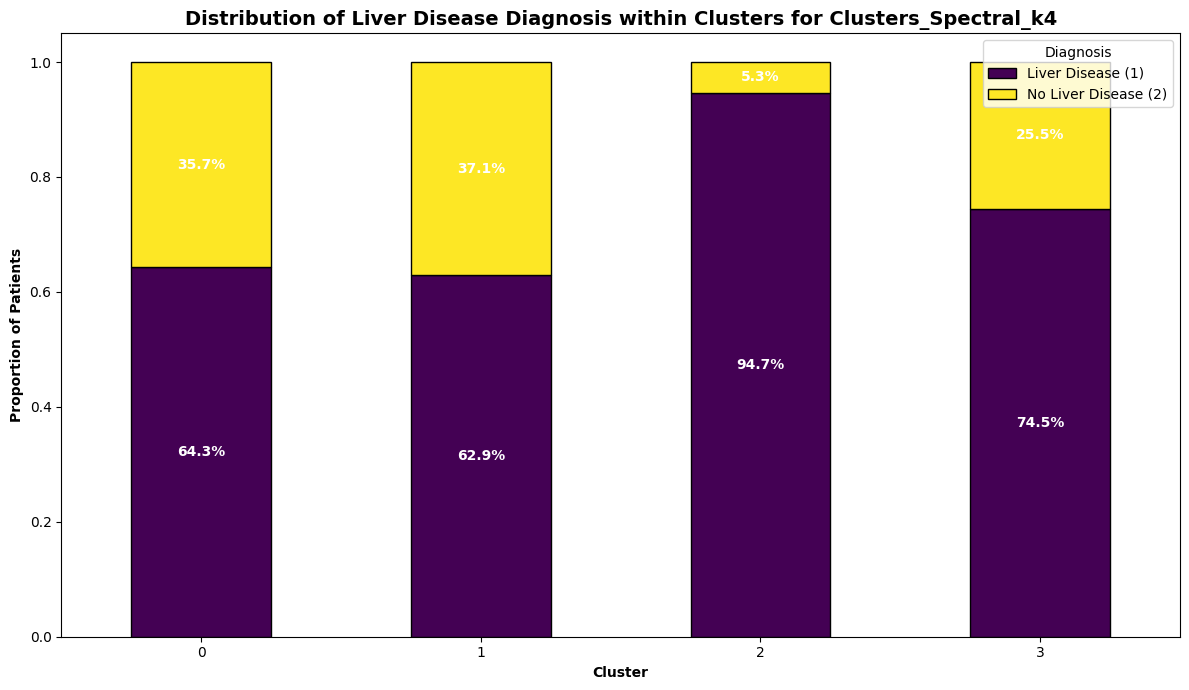

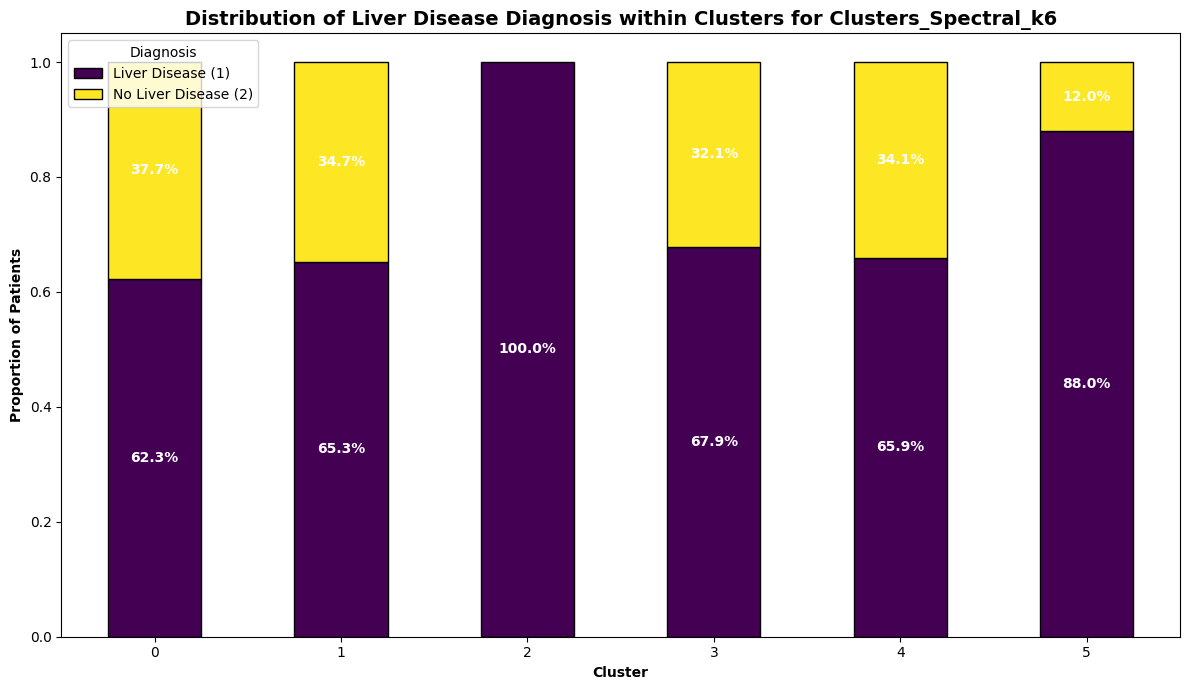

In [12]:
def plot_label_distribution(cluster_col):
    label_counts = df.groupby([cluster_col, 'Label']).size().unstack(fill_value=0)
    
    label_proportions = label_counts.divide(label_counts.sum(axis=1), axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    if 1 not in label_proportions.columns:
        label_proportions[1] = 0
    if 2 not in label_proportions.columns:
        label_proportions[2] = 0
    label_proportions = label_proportions[[1, 2]]


    label_proportions.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', edgecolor='black')
    
    ax.set_title(f'Distribution of Liver Disease Diagnosis within Clusters for {cluster_col}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cluster', fontweight='bold')
    ax.set_ylabel('Proportion of Patients', fontweight='bold')
    ax.legend(title='Diagnosis', labels=['Liver Disease (1)', 'No Liver Disease (2)'])
    ax.tick_params(axis='x', rotation=0)
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 0.01:
            x, y = p.get_xy()
            ax.text(x + width / 2, 
                    y + height / 2, 
                    f'{height:.1%}', 
                    ha='center', 
                    va='center',
                    color='white',
                    fontweight='bold',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

for method in spectral_methods:
    plot_label_distribution(method)

## Gender Distribution

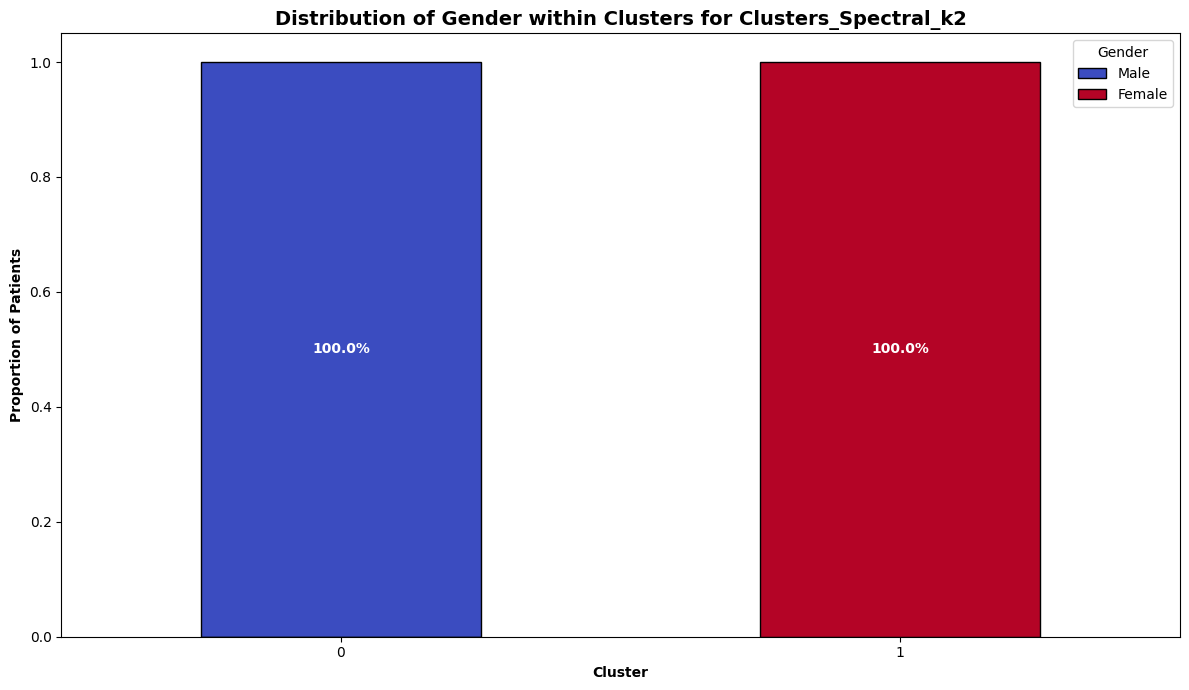

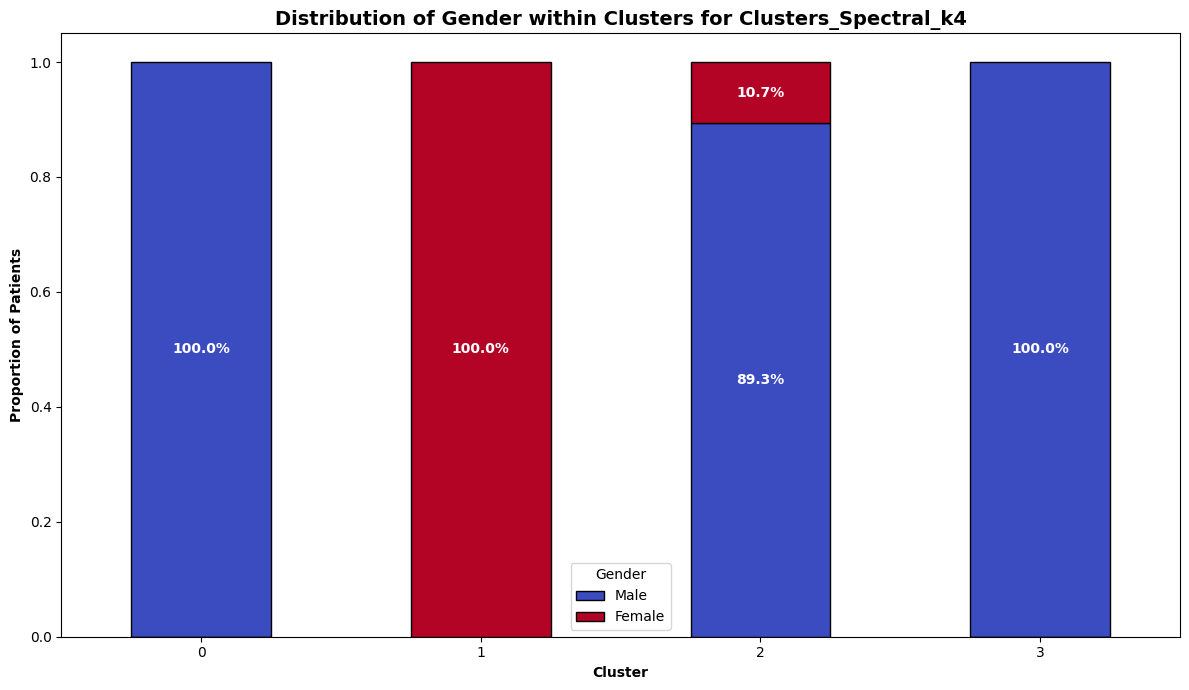

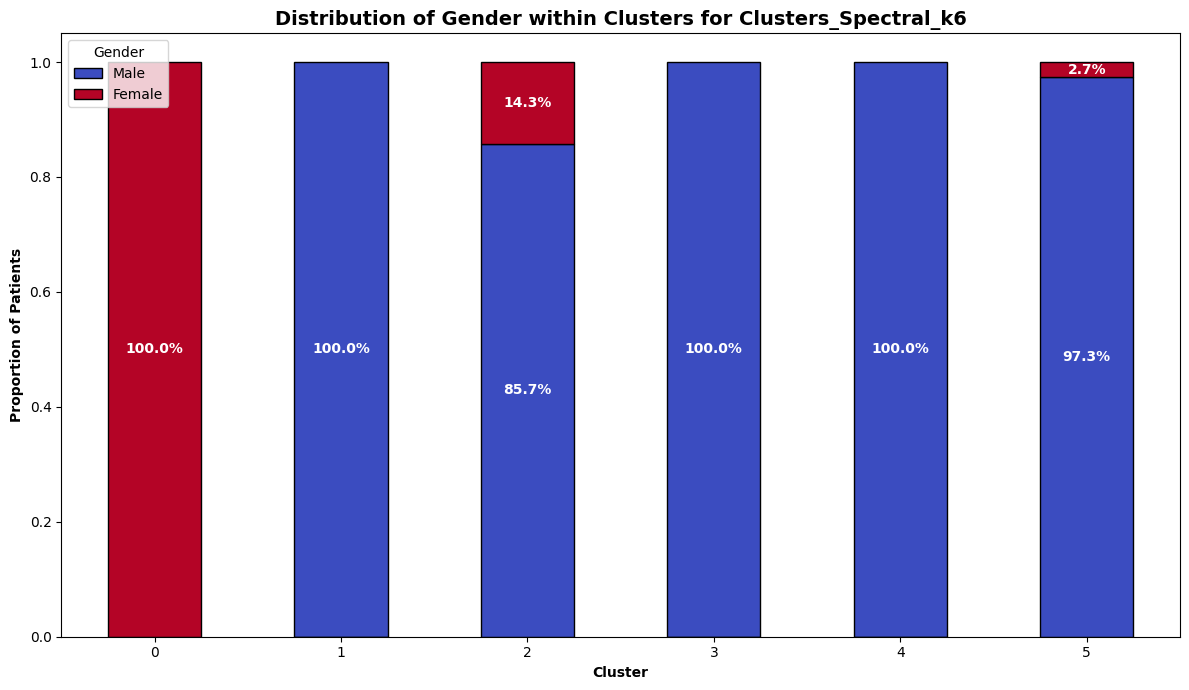

In [103]:
def plot_gender_distribution(cluster_col):
    gender_counts = df.groupby([cluster_col, 'Gender']).size().unstack(fill_value=0)
    
    gender_proportions = gender_counts.divide(gender_counts.sum(axis=1), axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    if 'Male' not in gender_proportions.columns:
        gender_proportions['Male'] = 0
    if 'Female' not in gender_proportions.columns:
        gender_proportions['Female'] = 0
    gender_proportions = gender_proportions[['Male', 'Female']]
    
    gender_proportions.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm', edgecolor='black')
    
    ax.set_title(f'Distribution of Gender within Clusters for {cluster_col}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cluster', fontweight='bold')
    ax.set_ylabel('Proportion of Patients', fontweight='bold')
    ax.legend(title='Gender')
    ax.tick_params(axis='x', rotation=0)
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 0.01:
            x, y = p.get_xy()
            ax.text(x + width / 2, 
                    y + height / 2, 
                    f'{height:.1%}', 
                    ha='center', 
                    va='center',
                    color='white',
                    fontweight='bold',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

for method in spectral_methods:
    plot_gender_distribution(method)